In [1]:
import warnings
warnings.filterwarnings("ignore")

import pytorch_lightning as pl
from omegaconf import OmegaConf
import torch
from dabs.src.systems import viewmaker_original
from tqdm import tqdm
import os 
from torchvision.utils import save_image
import torch.nn.functional as F

import torchattacks as ta

# config = OmegaConf.load('/workspace/dabs/conf/ceva.yaml')
# config.dataset = OmegaConf.load('/workspace/dabs/conf/dataset/lfw112.yaml')
# config.model = OmegaConf.load('/workspace/dabs/conf/model/jit_model.yaml')
# system = viewmaker_original.CevaViewmakerSystem(config)

dataset ='traffic'
part = 'val'
num_views = 1
attack = 'FGSM'




if dataset == 'traffic':
    conf_yaml = '/workspace/dabs/conf/traffic.yaml'
    conf_dataset_yaml = '/workspace/dabs/conf/dataset/traffic_sign_small.yaml'
    conf_model_yaml = '/workspace/dabs/conf/model/traffic_model.yaml'
    ckpt = '/workspace/dabs/exp/models/traffic_budget_budget=0.005/model.ckpt'
    systemClass = viewmaker_original.TrafficViewMaker
    batch_size = 32
    
    root = '/workspace/dabs/data/adv_data/traffic_sign/FGSM/'+part

    label_counters ={}

    def save_func(original,views_similarities,label, class_names):
        path = os.path.join(root, class_names[label])
        if not os.path.exists(path):
            os.makedirs(path)

        if label in label_counters:
            label_counters[label] += 1
        else:
            label_counters[label] = 0

        save_image(original,f'{path}/{label_counters[label]:05d}_original.jpg')

        for j in range(len(views_similarities)):
            unnormalized_view = views_similarities[j]
            save_image(unnormalized_view,f'{path}/{label_counters[label]:05d}_view_{j+1}.jpg')

elif dataset == 'lfw':
    conf_yaml = '/workspace/dabs/conf/ceva.yaml'
    conf_dataset_yaml = '/workspace/dabs/conf/dataset/lfw_112.yaml'
    conf_model_yaml = '/workspace/dabs/conf/model/ceva_model.yaml'
    ckpt = '/workspace/dabs/exp/models/traffic_budget_budget=0.005/model.ckpt'
    systemClass = viewmaker_original.CevaViewmakerSystem
    batch_size = 32
    
    root = '/workspace/dabs/data/adv_data/lfw/date/experiment_name/'+part

    label_counters ={}

    def save_func(original,views_similarities,label, class_names):
        path = os.path.join(root, class_names[label])
        if not os.path.exists(path):
            os.makedirs(path)

        if label in label_counters:
            label_counters[label] += 1
        else:
            label_counters[label] = 0

        save_image(original,f'{path}/{label_counters[label]:04d}_original.jpg')

        for j in range(len(views_similarities)):
            unnormalized_view, similarity = views_similarities[j]
            save_image(unnormalized_view,f'{path}/{label_counters[label]:04d}_view_{j+1}_sim_{similarity:.3f}.jpg')

elif dataset == 'birds':
    conf_yaml = '/workspace/dabs/conf/birds.yaml'
    conf_dataset_yaml = '/workspace/dabs/conf/dataset/cu_birds_small.yaml'
    conf_model_yaml = '/workspace/dabs/conf/model/birds_model.yaml'
    ckpt = '/workspace/dabs/exp/models/birds_dyn_sweep_budget=0.025/model.ckpt'
    systemClass = viewmaker_original.BirdsViewMaker
    batch_size = 12
    
    root = '/workspace/dabs/data/adv_data/cu_birds/FGSM/'+part

    label_counters ={}

    def save_func(original,views_similarities,label, class_names):
        path = os.path.join(root, class_names[label])
        if not os.path.exists(path):
            os.makedirs(path)

        if label in label_counters:
            label_counters[label] += 1
        else:
            label_counters[label] = 0

        save_image(original,f'{path}/{label_counters[label]:04d}_original.jpg')

        for j in range(len(views_similarities)):
            unnormalized_view = views_similarities[j]
            save_image(unnormalized_view,f'{path}/{label_counters[label]:04d}_view_{j+1}.jpg')


print('loading config...')
config = OmegaConf.load(conf_yaml)
config.dataset = OmegaConf.load(conf_dataset_yaml)
config.model = OmegaConf.load(conf_model_yaml)
config.dataset.batch_size = batch_size
config.debug = True
pl.seed_everything(config.trainer.seed)

print('loading VM...')
if 'model.ckpt' in ckpt:
    system = torch.load(ckpt)
else:
    system = systemClass(config)
    system.setup('')
    system.load_state_dict(torch.load(ckpt)['state_dict'],strict=False)

system.cuda()
system.eval()


print('loading loader...')
if part == 'train':
    loader = system.train_dataloader()
else :
    loader = system.val_dataloader()

if dataset =='birds':
    with open('/workspace/dabs/data/natural_images/cu_birds/CUB_200_2011/classes.txt', 'r') as f:
        image_info = [line.split('\n')[0].split(' ', 1) for line in f.readlines()]
    class_names = {(int(a[0])-1):a[1] for a in image_info}


    from types import MethodType
    def new_forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x

    threat_model  = system.model.birds_model.copy()
    threat_model.forward = MethodType(new_forward, threat_model)

elif dataset =='traffic':
    class_names = [str(i) for i in range(43)] # map between label index and class name
   
    from types import MethodType
    def forward_original(self, x):
        # transform the input
        x = self.stn(x)

        # Perform forward pass
        x = self.bn1(F.max_pool2d(F.leaky_relu(self.conv1(x)),2))
        x = self.conv_drop(x)
        x = self.bn2(F.max_pool2d(F.leaky_relu(self.conv2(x)),2))
        x = self.conv_drop(x)
        x = self.bn3(F.max_pool2d(F.leaky_relu(self.conv3(x)),2))
        x = self.conv_drop(x)
        x = x.view(-1, 250*2*2)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    threat_model  = system.model.traffic_model.copy()
    threat_model.forward = MethodType(forward_original, threat_model)

else:
    class_names = list(loader.dataset.class_to_index.keys()) # map between label index and class name


if attack == 'FGSM':
    atk = ta.FGSM(threat_model, eps=0.005) #, alpha=2/255, steps=4)
elif attack == 'PGD':
    atk = ta.PGD(threat_model, eps=0.025, alpha=0.025/8, steps=10)

atk.set_normalization_used(mean=loader.dataset.dataset.MEAN, std=loader.dataset.dataset.STD)
    


def calc_views(img,orig_embeds):
    views1, unnormalized_view1 = system.view(img.unsqueeze(0), True)
    unnormalized_view1 = torch.clamp(unnormalized_view1, 0, 1.0).squeeze()
    views_embeds = system.model.forward([system.normalize(unnormalized_view1)]).squeeze()
    similarities = (orig_embeds * views_embeds).sum()/(orig_embeds.norm()*views_embeds.norm())
    return unnormalized_view1 , similarities
    

for index , img , labels in tqdm(loader):
    img = img.cuda()
    orig_embeds = system.model.forward([system.normalize(img)])
    for i in range(len(img)):
        views_similarities = [ calc_views(img[i],orig_embeds[i]) for jj in range(num_views)]
        class_i = labels[i].item()
        
        original = img[i].cpu()
        views_similarities = [ (v.cpu(),s.cpu()) for v,s in views_similarities]
        # save_func(original,views_similarities,class_i,class_names)
            


Global seed set to 0


loading config...
loading VM...
loading loader...


  0%|          | 0/241 [00:00<?, ?it/s]


In [ ]:
for index , img , labels in tqdm(loader):
    img = img.cuda()
    labels = labels.cuda()
    

In [2]:
import matplotlib.pyplot as plt

In [8]:
i=0
a = atk(img[i],labels[i].unsqueeze(0))

In [15]:
b = system.unnormalize(atk(system.normalize(img[i]),labels[i].unsqueeze(0))).cpu()

In [19]:
torch.abs(b[0].cpu()-img[0].cpu()).mean()

tensor(0.0050)

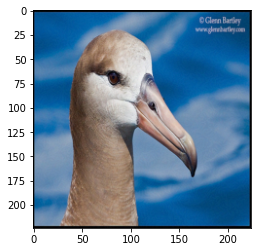

In [16]:
plt.imshow(b[0].cpu().detach().permute(1,2,0))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


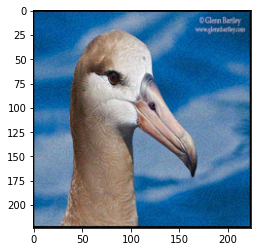

In [9]:
plt.imshow(a[0].cpu().detach().permute(1,2,0))

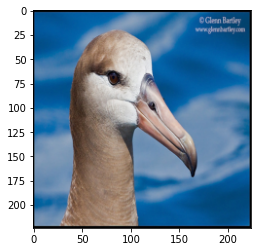

In [7]:
plt.imshow(img[0].cpu().detach().permute(1,2,0))

In [ ]:
for i in range(len(img)):
    adv_views = [ system.unnormalize(atk(system.normalize(img[i]),labels[i].unsqueeze(0))).cpu() for jj in range(num_views)]
    class_i = labels[i].cpu().item()
    original = img[i].cpu()
    save_func(original,adv_views,class_i,class_names)
            

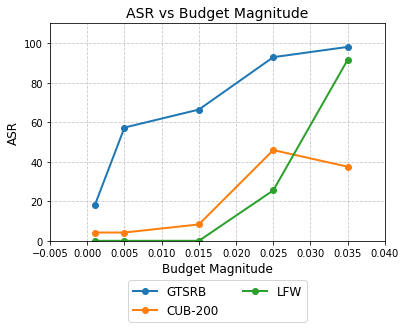

In [30]:
import matplotlib.pyplot as plt

# Define the data for the x and y axes
x = [0.035, 0.025, 0.015, 0.005, 0.001]
y = [98.1, 92.9, 66.4, 57.3,  17.9]

yb = [37.5, 45.9, 8.3, 4.2,  4.2]
yc = [91.59, 25.52, 0 ,0 ,0]

# Create the figure and axes
fig, ax = plt.subplots()

# Plot the data
ax.plot(x, y, linewidth=2, linestyle='-', marker='o', markersize=6, label='GTSRB')
ax.plot(x, yb, linewidth=2, linestyle='-', marker='o', markersize=6, label='CUB-200')
ax.plot(x, yc, linewidth=2, linestyle='-', marker='o', markersize=6, label='LFW')

# Add axis labels
ax.set_xlabel('Budget Magnitude', fontsize=12)
ax.set_ylabel('ASR', fontsize=12)

# Add a grid
ax.grid(linestyle='--', alpha=0.7)

# Add a title
ax.set_title('ASR vs Budget Magnitude', fontsize=14)

# Set the axis limits
ax.set_xlim(-0.005, 0.04)
ax.set_ylim(0, 110)
# ax.legend()
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=2, fontsize=12)

# Show the plot
plt.show()
